<a href="https://colab.research.google.com/github/TaherLilywala/NNFL-Projects/blob/main/NNFL_Project_Group_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
This is the submission for the Group Project for the course NNFL
####Group 10
#####Taher Yunus Lilywala - 2018B1A70609G
#####Shreyas Sarangi - 2018A7PS1023G
#####Aastha Bhargava - 2019A7PS0421G
#####Keyur Gondhalekar - 2018A7PS0118G


---------------------------------------------------------------------------------------
## Importing libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import keras

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import os

## Dataset Overview

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/NNFL Stuff/train.csv')
#check data shape
data.shape

Mounted at /content/drive


(34887, 2)

In [ ]:
#preview first 5 row of data
data.head(5)

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4826
1,Digust,531
2,Fear,4958
3,Happy,8723
4,Sad,5902
5,Surprise,3916
6,Neutral,6031


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


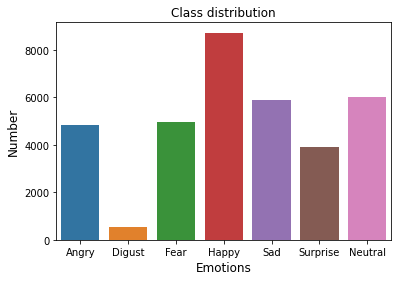

In [ ]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

Plotting The Images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

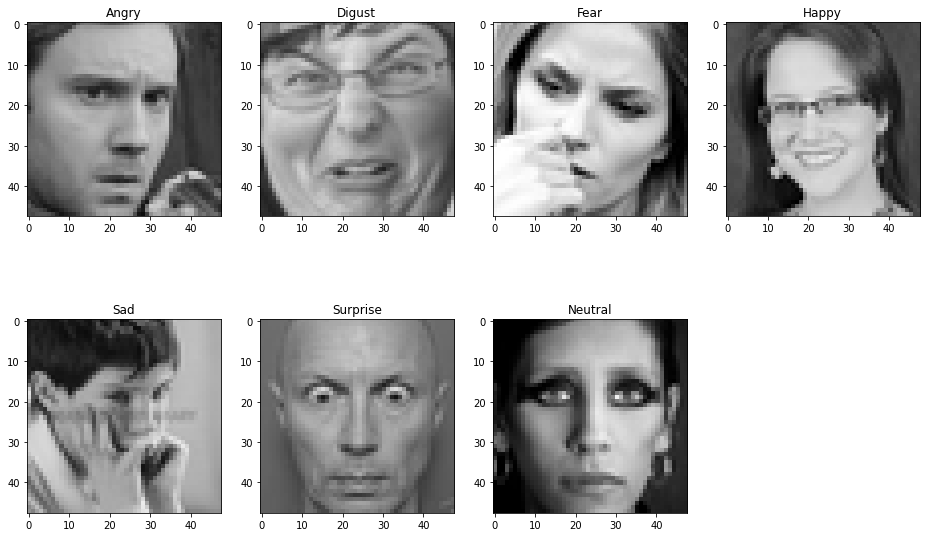

In [ ]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

----------------------------------------------------------------------------------
## Pre-processing data
#### Summary:
1. Splitting dataset into 3 parts: train, validation, test
1. Convert strings to lists of integers
1. Reshape to 48x48 and normalise grayscale image with 255.0
1. Perform one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

In [ ]:
#Splitting the data into training and validation set
data_train, data_val = train_test_split(data, train_size=0.8, test_size=0.2)
print("train shape: {}, \nvalidation shape: {}".format(data_train.shape, data_val.shape))

train shape: (27909, 2), 
validation shape: (6978, 2)


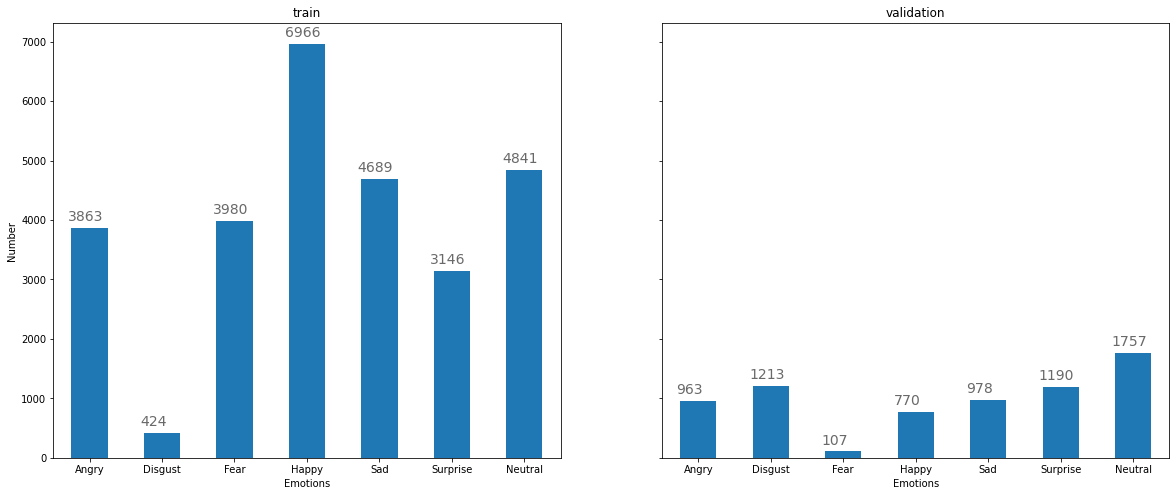

In [ ]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,2, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
plt.show()

#### Initializing Parameters

In [ ]:
#Initializing Parameters
num_classes = 7 
width = 48
height = 48
num_epochs = 30
batch_size = 30

In [ ]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


train _X shape: {},  train _Y shape: (27909, 48, 48, 1)
val _X shape: {},  val _Y shape: (6978, 48, 48, 1)


#### Data Augmentation

In [ ]:
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        width_shift_range=0.1,
                        height_shift_range=0.1)

----------------------------------------------------------------------------------
## CNN Model

### CNN Architecture:  
* Conv -> BN -> Conv -> BN -> MaxPooling 
* Conv -> BN -> Conv -> BN -> Conv -> BN -> MaxPooling 

* Flatten
* Dense -> BN
* Dense -> BN

* Dense (output)

In [ ]:
model = Sequential()

#Convol
model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))


#Flatten
model.add(Flatten())

#Dense set 1
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

#Dense set 2
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())


#Output layer
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 128)       1280      
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 128)       147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 23, 128)       5

In [ ]:
# data generator


#es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True) #alternate overfitting precaution
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                #callbacks = [es],
                                callbacks=[reduce_lr],
                                validation_data=(val_X, val_Y))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
930/930 - 39s - loss: 1.7660 - accuracy: 0.3024 - precision: 0.5283 - recall: 0.0508 - val_loss: 2.8027 - val_accuracy: 0.1536 - val_precision: 0.1482 - val_recall: 0.1296
Epoch 2/30
930/930 - 31s - loss: 1.5104 - accuracy: 0.4128 - precision: 0.6731 - recall: 0.1750 - val_loss: 1.4346 - val_accuracy: 0.4488 - val_precision: 0.6425 - val_recall: 0.2498
Epoch 3/30
930/930 - 31s - loss: 1.3701 - accuracy: 0.4745 - precision: 0.7078 - recall: 0.2505 - val_loss: 1.2932 - val_accuracy: 0.5070 - val_precision: 0.7217 - val_recall: 0.2617
Epoch 4/30
930/930 - 30s - loss: 1.2894 - accuracy: 0.5092 - precision: 0.7126 - recall: 0.2980 - val_loss: 1.2446 - val_accuracy: 0.5155 - val_precision: 0.6580 - val_recall: 0.3608
Epoch 5/30
930/930 - 30s - loss: 1.2326 - accuracy: 0.5306 - precision: 0.7260 - recall: 0.3300 - val_loss: 1.2164 - val_accuracy: 0.5344 - val_precision: 0.7091 - val_recall: 0.3672
Epoch 6/30
930/930 - 30s - loss: 1.1813 - accuracy: 0.5554 - precision: 0.7271 - reca

In [ ]:
model.save("Model_Final.h5")

## Visualize Training Performance

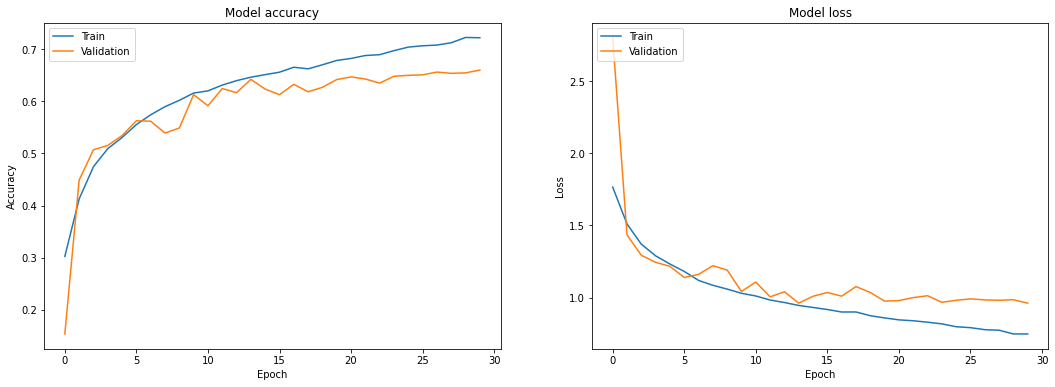

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Confusion Matrix

In [ ]:
test_true = np.argmax(val_Y, axis=1)
test_pred = np.argmax(model.predict(val_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.6601


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

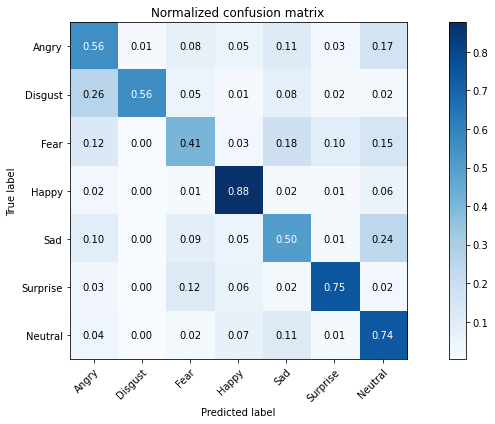

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()